# ML_LOB
- 该文件夹参考自 https://link.zhihu.com/?target=https%3A//github.com/rorysroes/SGX-Full-OrderBook-Tick-Data-Trading-Strategy 

- 采用ML方法对有限订单簿动态进行建模


- 根据原项目的结果，采用ExtraTreesClassifier取得的结果更好。由于比赛时间关系，先从该方法开始复现，若后续有时间再补全其他方法

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

从订单簿中提取数据：bid1, bid2, bid3, ask1, ask2, ask3

In [4]:
class One_Order_Book:
    def __init__(self, date='12-03-25', name='stock_27.jsonl'):
        url = "/home/qinry/ubiquant_trading_competition/dataset/collected_data/2023-" + date + '/' + name
        self.df = pd.read_json(url, lines=True)
        # print(df)
    def __len__(self):
        return len(self.df)
    def begin(self):
        self.current_idx = 0
    def get_next_data(self, N):
        time = self.df.iloc[self.current_idx]['lob']['localtime']
        price = self.df.iloc[self.current_idx]['lob']['last_price']
        bid_price = self.df.iloc[self.current_idx]['lob']['bidprice'][0:3]
        bid_volume = self.df.iloc[self.current_idx]['lob']['bidvolume'][0:3]
        ask_price = self.df.iloc[self.current_idx]['lob']['askprice'][0:3]
        ask_volume = self.df.iloc[self.current_idx]['lob']['askvolume'][0:3]
        trade_volume = self.df.iloc[self.current_idx]['lob']['trade_volume']
        # print(price)
        # next_price = self.df.iloc[self.current_idx+1]['lob']['last_price'] if self.current_idx < self.__len__()-1 else price
        self.current_idx += 1
        # return {'price':price, 'next_price':next_price, 'bid_volume':bid_volume, 'ask_price':ask_price, \
        #     'ask_volume':ask_volume, 'bid_price':bid_price}, self.current_idx == self.__len__()
        return {'time':time, 'price':price, 'bid_volume':bid_volume, 'ask_price':ask_price, 'ask_volume':ask_volume, \
                'bid_price':bid_price, 'trade_volume':trade_volume}, self.current_idx == N
    def show(self):
        print(self.df.iloc[self.current_idx]['lob'])
        print(self.df.iloc[self.current_idx]['lob']['localtime'])
        print(self.df.iloc[self.current_idx]['lob']['askprice'][0:3])

def get_data1(order_book, N):
    price = []
    bid1_price = []
    ask1_price = []
    bid1_volume = []
    ask1_volume = []
    timeline = []

    end_flag = 0
    order_book.begin()
    while not end_flag:
        return_dict, end_flag = order_book.get_next_data(N)
        price.append(return_dict['price'])
        bid1_price.append(return_dict['bid_price'][0])
        ask1_price.append(return_dict['ask_price'][0])
        bid1_volume.append(return_dict['bid_volume'][0])
        ask1_volume.append(return_dict['ask_volume'][0])
        timeline.append(return_dict['time'])
        # state_volume = return_dict['trade_volume']
        
    return np.array(timeline), np.array(price), np.array(bid1_price), np.array(ask1_price), \
        np.array(bid1_volume), np.array(ask1_volume)


In [5]:
# 自定义训练标签，0代表空仓，1代表多仓
# 信息获取间隔为1，trade操作的时间单位为7: 若当前bid_price高于未来expect_period时间内ask price的最小值，则认为此时买入可以在较短时间fill
def get_trade_label(time, bid, ask, start, end, period, fee = 0.01):
    label = []
    index_start = np.where(time >= start)[0][0]
    index_end = np.where(time <= end)[0][-1]
    for i in range(index_start, index_end + 1, 1):
        index = np.where(time <= time[i] + 7 * period)[0][-1]
        if bid[i] > (min(ask[i: index + 1]) + fee): label.append(1)
        else: label.append(0)
    return label


下面，先尝试根据LOB提取Depth Ratio和OBI因子（手动提取）。一种简单OBI提取过程是采用如下计算方式：
$$
    OBI = \frac{Q_b-Q_a}{Q_a+Q_b}
$$

In [6]:
def simple_OBI(time, bid_volume, ask_volume, start, end):
    index_start = np.where(time >= start)[0][0]
    index_end = np.where(time <= end)[0][-1]
    OBI = (ask_volume[index_start: index_end + 1] - bid_volume[index_start: index_end + 1])/(bid_volume[index_start: index_end + 1] + ask_volume[index_start: index_end + 1])
    depth_ratio = ask_volume[index_start: index_end + 1]/bid_volume[index_start: index_end + 1]
    return OBI, depth_ratio

Text(0, 0.5, 'Level-1 OBI')

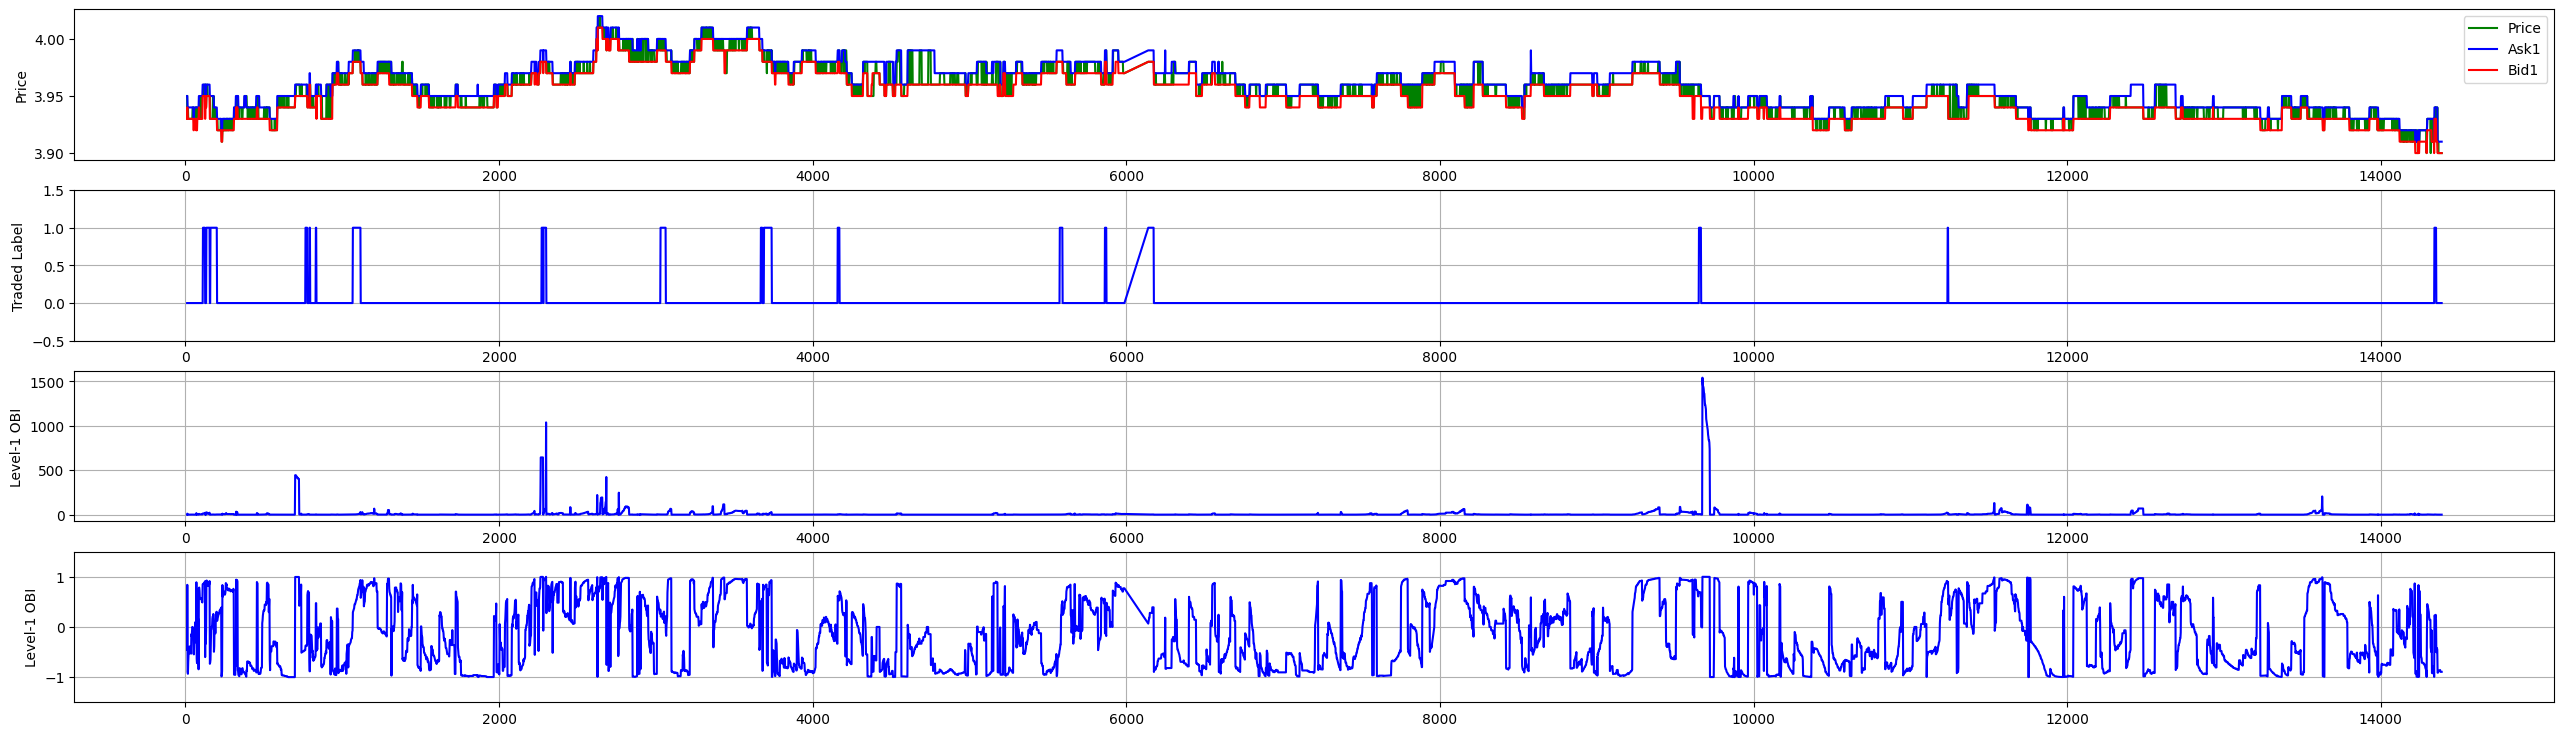

In [7]:
order_book = One_Order_Book(name = 'stock_23.jsonl')
timeline, price, bid1_price, ask1_price, bid1_volume, ask1_volume = get_data1(order_book, len(order_book))
trade_label = get_trade_label(timeline, bid1_price, ask1_price, 0, timeline[-1], 10)
level1_OBI, depth_ratio = simple_OBI(timeline, bid1_volume, ask1_volume, 0, timeline[-1])

plt.figure(figsize=(32,9))
plt.subplot(411)
plt.plot(timeline, price, color = 'g', label = 'Price')
plt.plot(timeline, ask1_price, color = 'b', label = 'Ask1')
plt.plot(timeline, bid1_price, color = 'r', label = 'Bid1')
plt.ylabel("Price")
plt.legend(loc = 1)

plt.subplot(412)
plt.grid()
plt.ylim(-0.5, 1.5)
plt.plot(timeline, trade_label, color = 'b')
plt.ylabel("Traded Label")

plt.subplot(413)
plt.grid()
plt.plot(timeline, depth_ratio, color = 'b')
plt.ylabel("Level-1 OBI")

plt.subplot(414)
plt.grid()
plt.ylim(-1.5, 1.5)
plt.plot(timeline, level1_OBI, color = 'b')
plt.ylabel("Level-1 OBI")



**下面，将使用多层的订单簿信息，并使用加权方式计算Depth Ratio和OBI**

In [8]:
def get_data_m(order_book, N):
    bid2_price = []
    ask2_price = []
    bid2_volume = []
    ask2_volume = []
    bid3_price = []
    ask3_price = []
    bid3_volume = []
    ask3_volume = []

    end_flag = 0
    order_book.begin()
    while not end_flag:
        return_dict, end_flag = order_book.get_next_data(N)
        bid2_price.append(return_dict['bid_price'][1])
        ask2_price.append(return_dict['ask_price'][1])
        bid2_volume.append(return_dict['bid_volume'][1])
        ask2_volume.append(return_dict['ask_volume'][1])
        bid3_price.append(return_dict['bid_price'][2])
        ask3_price.append(return_dict['ask_price'][2])
        bid3_volume.append(return_dict['bid_volume'][2])
        ask3_volume.append(return_dict['ask_volume'][2])
        # state_volume = return_dict['trade_volume']
    return np.array(bid2_volume), np.array(bid3_volume), np.array(ask2_volume), np.array(ask3_volume), \
        np.array(bid2_price), np.array(bid3_price), np.array(ask2_price), np.array(ask3_price)

def weighted_OBI(time, start, end, bid1, bid2, bid3, ask1, ask2, ask3, weight = [0.5, 0.3, 0.2]):
    index_start = np.where(time >= start)[0][0]
    index_end = np.where(time <= end)[0][-1]
    weighted_ask = weight[0] * ask1[index_start: index_end + 1] + weight[1] * ask2[index_start: index_end + 1] + \
        weight[2] * ask3[index_start: index_end + 1]
    weighted_bid = weight[0] * bid1[index_start: index_end + 1] + weight[1] * bid2[index_start: index_end + 1] + \
        weight[2] * bid3[index_start: index_end + 1]
    weighted_depth_ratio = weighted_ask/weighted_bid
    OBI = (weighted_ask - weighted_bid)/(weighted_ask + weighted_bid)
    return OBI, weighted_depth_ratio

Text(0, 0.5, 'weighted OBI')

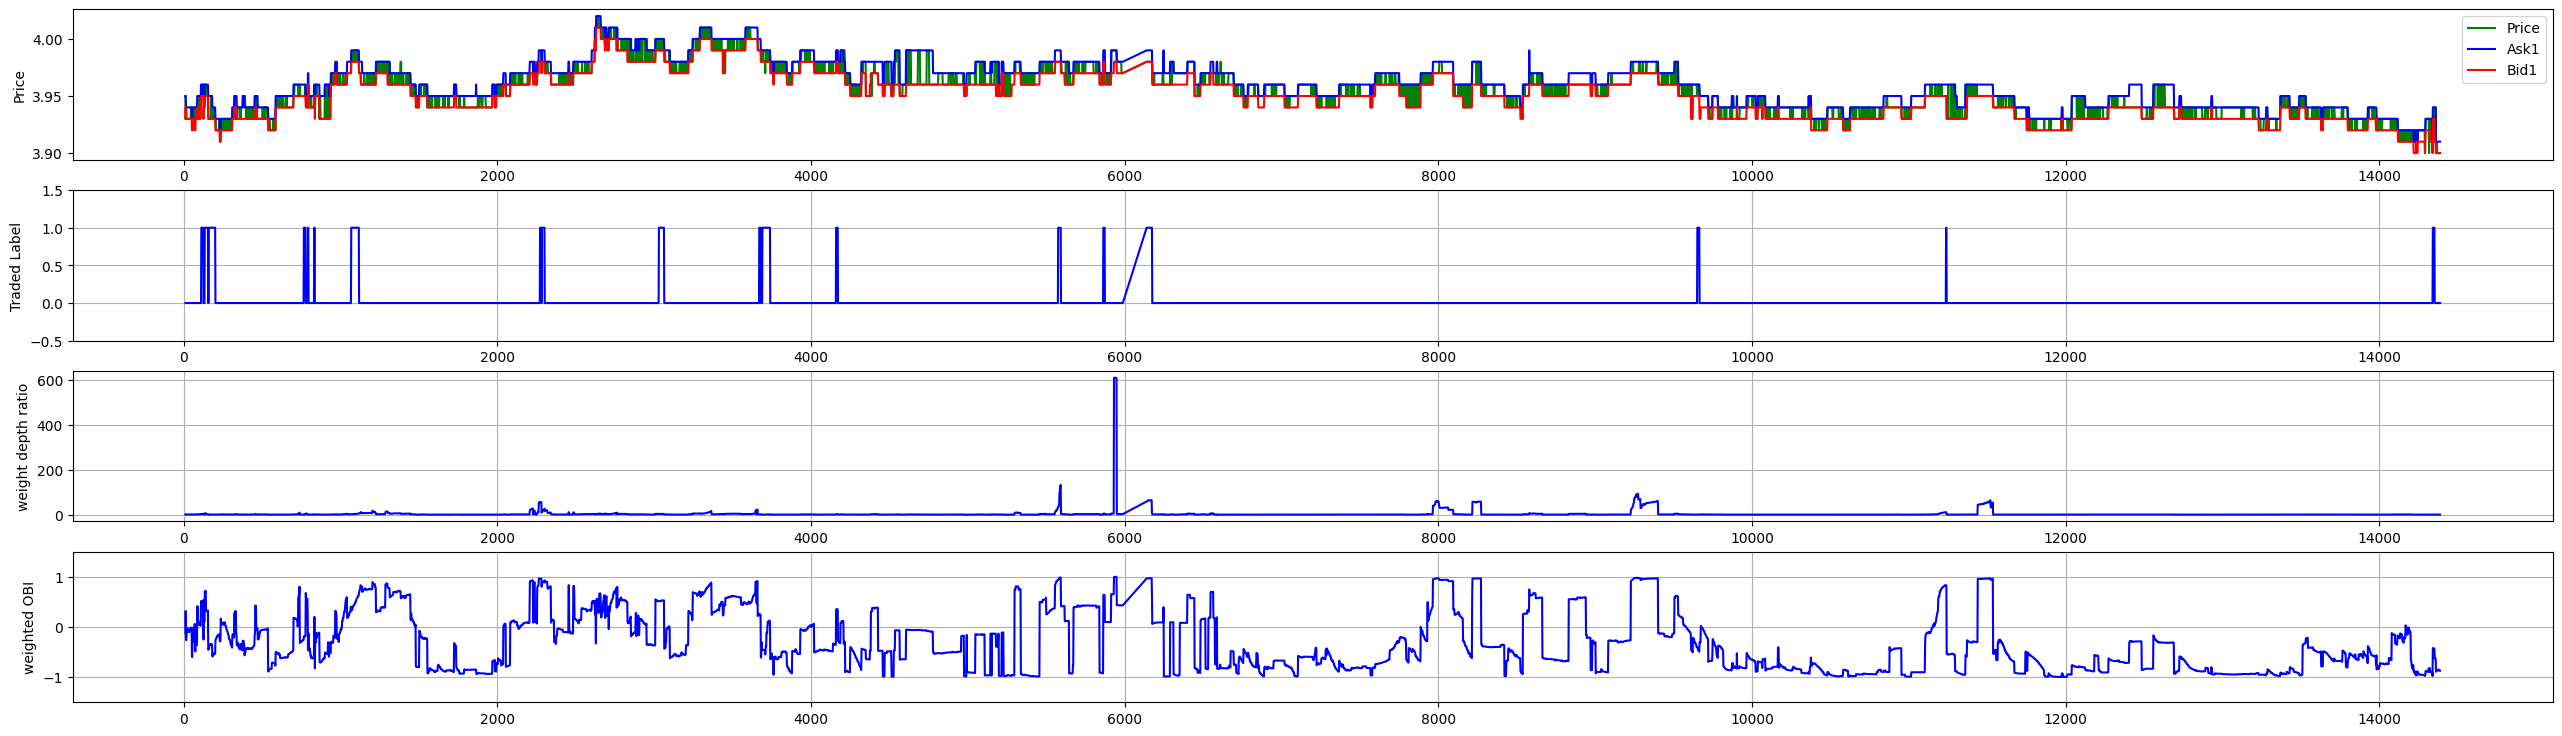

In [9]:
order_book = One_Order_Book(name = 'stock_23.jsonl')
timeline, price, bid1_price, ask1_price, bid1_volume, ask1_volume = get_data1(order_book, len(order_book))
trade_label = get_trade_label(timeline, bid1_price, ask1_price, 0, timeline[-1], 10)
bid2_volume, bid3_volume, ask2_volume, ask3_volume, _, _, _, _ = get_data_m(order_book, len(order_book))
w_OBI, w_depth_ratio = weighted_OBI(timeline, 0, timeline[-1], bid1_volume, bid2_volume, bid3_volume, ask1_volume, ask2_volume, ask3_volume)

plt.figure(figsize=(32,9))
plt.subplot(411)
plt.plot(timeline, price, color = 'g', label = 'Price')
plt.plot(timeline, ask1_price, color = 'b', label = 'Ask1')
plt.plot(timeline, bid1_price, color = 'r', label = 'Bid1')
plt.ylabel("Price")
plt.legend(loc = 1)

plt.subplot(412)
plt.grid()
plt.ylim(-0.5, 1.5)
plt.plot(timeline, trade_label, color = 'b')
plt.ylabel("Traded Label")

plt.subplot(413)
plt.grid()
plt.plot(timeline, w_depth_ratio, color = 'b')
plt.ylabel("weight depth ratio")

plt.subplot(414)
plt.grid()
plt.ylim(-1.5, 1.5)
plt.plot(timeline, w_OBI, color = 'b')
plt.ylabel("weighted OBI")

## Rise Ratio + Depth Ratio + OBI
- Rise Ratio定义为ask1的斜率时间序列，相当于一个**future lagged return**
- 

In [10]:
# before_time是一个需要调的参数，是一个时间节点。在此节点前，rise ratio定义为当下ask1价格相对本轮初始ask1的涨幅；在此节点后，定义为一个moving return
def rise_ask(time, ask, before_time):
    rise_ratio = []
    index = np.where(time >= before_time)[0][0]
    for i in range(index):
        ratio = round((ask[i] - ask[0])/ask[0] * 100, 5)
        rise_ratio.append(ratio)
    for i in range(index, len(ask), 1):
        index_moving = np.where(time[:i] >= time[i] - before_time)[0][0]
        ratio = round((ask[i] - ask[index_moving])/ask[index_moving] * 100, 5)
        rise_ratio.append(ratio)
    return rise_ratio

Text(0, 0.5, 'weight depth ratio')

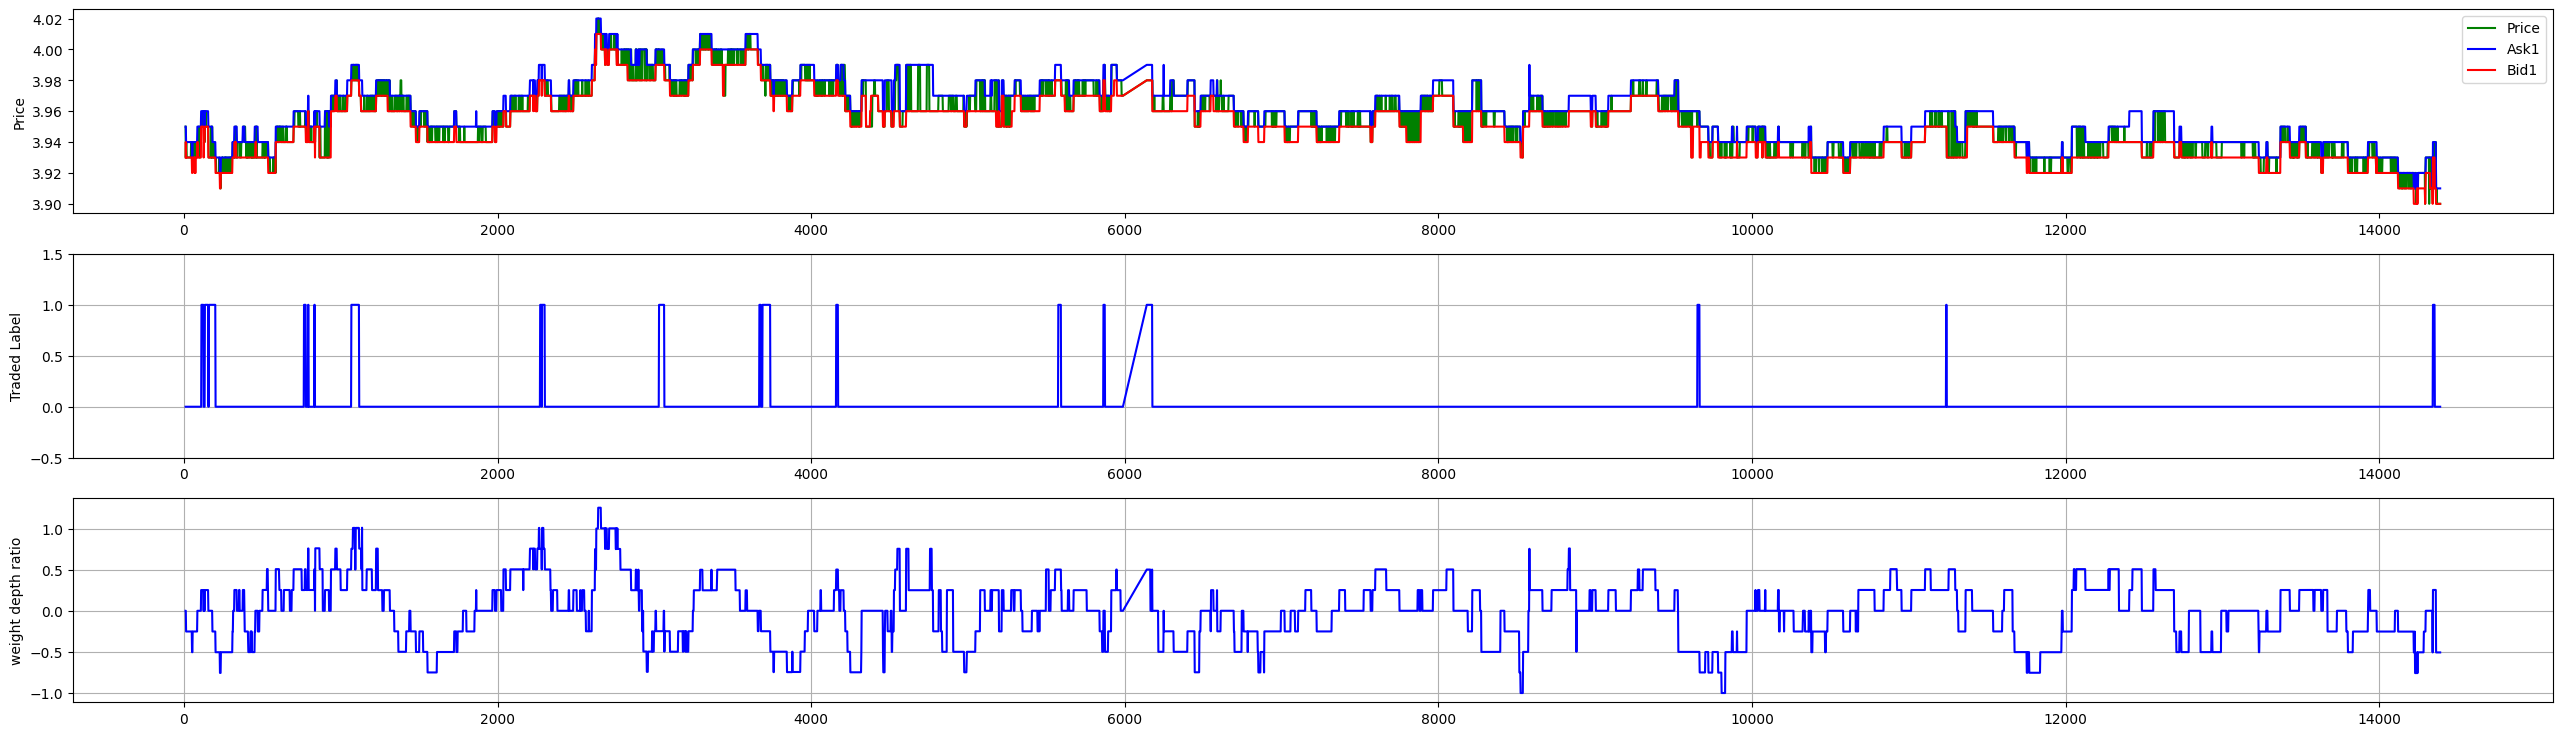

In [11]:
order_book = One_Order_Book(name = 'stock_23.jsonl')
timeline, price, bid1_price, ask1_price, bid1_volume, ask1_volume = get_data1(order_book, len(order_book))
trade_label = get_trade_label(timeline, bid1_price, ask1_price, 0, timeline[-1], 10)
# bid2_volume, bid3_volume, ask2_volume, ask3_volume, _, _, _, _ = get_data_m(order_book, len(order_book))
# w_OBI, w_depth_ratio = weighted_OBI(timeline, 0, timeline[-1], bid1_volume, bid2_volume, bid3_volume, ask1_volume, ask2_volume, ask3_volume)
rise_ratio = rise_ask(timeline, ask1_price, 400)

plt.figure(figsize=(32,9))
plt.subplot(311)
plt.plot(timeline, price, color = 'g', label = 'Price')
plt.plot(timeline, ask1_price, color = 'b', label = 'Ask1')
plt.plot(timeline, bid1_price, color = 'r', label = 'Bid1')
plt.ylabel("Price")
plt.legend(loc = 1)

plt.subplot(312)
plt.grid()
plt.ylim(-0.5, 1.5)
plt.plot(timeline, trade_label, color = 'b')
plt.ylabel("Traded Label")

plt.subplot(313)
plt.grid()
plt.plot(timeline, rise_ratio, color = 'b')
plt.ylabel("weight depth ratio")